# Data Ingestion

## Copy CSV files to S3

In [2]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


In [3]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [4]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"
s3_public_path_cities = "s3://ads508team5/cities"

# Destination Data:
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)


# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"
!aws s3 cp --recursive $s3_public_path_cities/ $s3_private_path_cities/ --exclude "*" --include "uscities.csv"

                           PRE cities/
                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/nyt/nyt-comments-2020.csv
copy: s3://ads508team5/cities/uscities.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/cities/uscities.csv


## Create Database, Tables and Parquets
### Database

In [5]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

#!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [6]:

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create Connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
# Create Database
database_name = "dbpoliticpulsecomment"

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


,database_name
0,dbpoliticpulsecomment
1,default


In [8]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [9]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


""


In [10]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,None,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,00:01.6


In [11]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


""


In [12]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter


In [13]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


In [14]:
# Create uscities table
table_name = "uscities"
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    city VARCHAR(45),
    state_id VARCHAR(2),
    state_name VARCHAR(30)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, table_name, s3_private_path_cities
)

pd.read_sql(statement, conn)

#with conn.cursor() as cursor:
#    for _, row in df_city.iterrows():
#        cursor.execute("INSERT INTO {}.{} VALUES ('{}', '{}', '{}')".format(database_name, table_name, row['city'], row['state_id'], row['state_name']))


""


### Parquets
#### Feature Selection and Creation
Prior creating a parquet table, tweeter and NYT comment tables are going to be combined under Comment Table in Athena where a feature creation is going to be performed. When the table is combined, we selected some features that would be benefit to our goal.

Selected features which could help on train the model are comment_id, comment_body, user_id, user_location, candidatepoll

In [15]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    u.state_id AS user_state,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(user_location) = lower(u.city) OR 
    lower(user_location) = lower(u.state_name) OR 
    lower(user_location) = lower(u.state_id)
WHERE
    LENGTH(tweet) > 3
UNION
SELECT DISTINCT
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    u.state_id as user_state,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(userLocation) = lower(u.city) OR 
    lower(userLocation) = lower(u.state_name) OR 
    lower(userLocation) = lower(u.state_id)
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

,rows


In [16]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,106394240.0,Joe Biden would have a much better chance of w...,57807721,Mickey McGovern,San Francisco,2020-04-10 16:02:07,0,16,nyt_comment,3,2,Trump
1,106319464.0,Joe Biden needs to be speaking now! Where is he?,26090123,Kathie,Warrington,2020-04-07 18:02:54,0,3,nyt_comment,0,1,Biden
2,106308376.0,Joe Biden was paid over $20 million last year ...,37435084,Common Ground,New York,2020-04-07 12:03:08,0,3,nyt_comment,0,1,Biden
3,108857760.0,Joe Biden has only recently condemned the loot...,78343265,KMW,New York City,2020-08-28 07:57:53,3,11,nyt_comment,2,1,Trump
4,108861520.0,Joe Biden will give us the absolutely best cha...,60104132,Tom,Bluffton SC,2020-08-28 13:22:13,1,14,nyt_comment,1,1,None


In [17]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [18]:
# SQL statement to execute (remove comment_id, user_name,)
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT DISTINCT user_location,
         user_state,
         comment_body,
         source,
         candidatepoll
FROM {}.{}
where candidatepoll is not null AND Length(comment_body)>1 AND length(user_location)>1""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)

,rows


In [19]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

""


In [20]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,candidatepoll=Biden
1,candidatepoll=__HIVE_DEFAULT_PARTITION__
2,candidatepoll=Trump


In [21]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter
4,uscities


In [22]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.322401e+18,AdamIShackleton,,#MinnesotaDemocrats #Dumbasses you all just #S...,0.0,0.0,tweet,2,0,Trump
1,1.322401e+18,Carlos Larios G.,urbana y rural,#AMLO #Trump #Elecciones2020 #USA https://t.co...,0.0,0.0,tweet,1,0,Trump
2,1.322401e+18,Mike Davey,high school coach,@GOPChairwoman @realDonaldTrump After a 36% de...,0.0,0.0,tweet,2,0,Trump
3,1.322401e+18,1.3216881597348332e+18,3.0,"""#Trump is trading in mistruths",0.0,NaN,tweet,1,0,Trump
4,1.322401e+18,None,None,"""#Trump is a lying",NaN,NaN,tweet,1,0,Trump


## Query Data

In [23]:
# Setup and check pre-requisites to create Database

#!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

In [24]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [27]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

#"user_state", 


In [28]:
df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])
#df_parquet_results_trump = df_parquet_results.dropna(subset = ['user_state'])
#df_parquet_results_trump = df_parquet_results[df_parquet_results['user_state'] != ' V']
df_parquet_results_trump.shape
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""WIN = trump https://t.co/v4yRMK4rrX",tweet,<NA>,Trump
1,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",tweet,<NA>,Trump
2,"""@BrettFavre @realDonaldTrump Principle’s are ...",tweet,<NA>,Trump
3,"""Anything Trump can do",tweet,2626.0,Trump
4,"""Trump is winning.",tweet,<NA>,Trump


In [29]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)

# "user_state",
df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden


# Data Exploration before Any Feature Transformation

In [30]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926684 entries, 0 to 333283
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   926684 non-null  string  
 1   source         926684 non-null  string  
 2   user_location  734725 non-null  string  
 3   candidatepoll  926684 non-null  category
dtypes: category(1), string(3)
memory usage: 29.2 MB


In [31]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434926 entries, 0 to 163918
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   434926 non-null  string  
 1   source         434926 non-null  string  
 2   user_location  309555 non-null  string  
 3   candidatepoll  434926 non-null  category
dtypes: category(1), string(3)
memory usage: 13.7 MB


In [32]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


tweet          534174
nyt_comment    392510
Name: source, dtype: Int64

In [33]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

tweet          373106
nyt_comment     61820
Name: source, dtype: Int64

In [34]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                       64393
NYC                    13502
California             11827
New York               11436
USA                     8575
                       ...  
2009-04-18 17:30:50        1
2008-05-24 10:28:50        1
 Inmobiliario              1
 Creole                    1
Reticulum                  1
Name: user_location, Length: 94255, dtype: Int64

In [ ]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

In [ ]:
df_parquet_results_biden['user_location'].value_counts()

In [ ]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

# Create EDA Overview Data Visualization

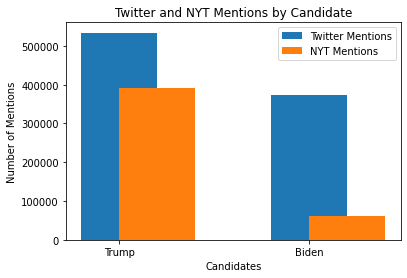

In [35]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

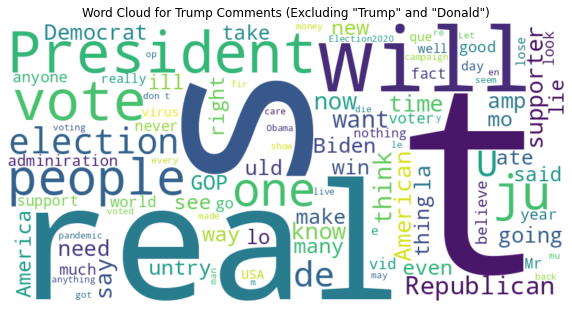

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['comment_body'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

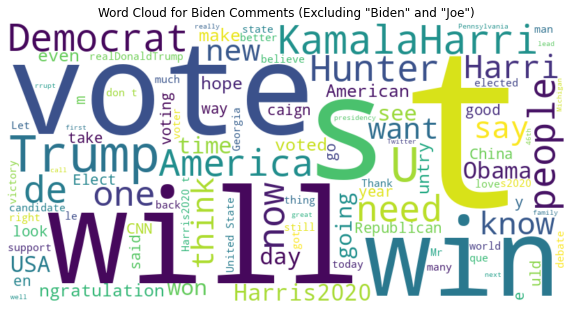

In [37]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['comment_body'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Feature Transformation and Data Cleaning

### Sentiment Labels Using Textblob and Stripping Out Non-English Text Entries with Fasttext.

### This code must be ran on Mac/Linux only. Windows is not compatible. Clean data from this code is stored in an S3 bucket and called below.

In [ ]:
#pip install langdetect

In [ ]:
#pip install fasttext-wheel

In [ ]:
#Use pretrained model
#!pip install textblob
#!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P /ADS508_GroupProject
#!ls -p /ADS508_GroupProject


In [ ]:
#!wget --no-check-certificate https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
#!mkdir -p /ADS508_GroupProject

In [ ]:
#import fasttext
#from textblob import TextBlob

# Load the pre-trained language identification model
#model_path = '/ADS508_GroupProject/lid.176.bin'  # Path to the pre-trained language identification model
#model = fasttext.load_model(model_path)

In [ ]:
# Function to detect language using FastText
def detect_language_fasttext(text):
    prediction = model.predict(text)
    language_code = prediction[0][0].split('__label__')[1]
    return language_code

# Function to analyze tweet sentiment to catch non english words
def analyze_tweet_sentiment(tweet_text):
    try:
        language = detect_language_fasttext(tweet_text)
        if language == 'en':
            analysis = TextBlob(tweet_text)
            return analysis.sentiment.polarity
        else:
            return None
    except:
        return None



In [ ]:
# Apply sentiment analysis to Trump data
#if __name__ == "__main__":
    
    #df_parquet_results_trump['sentiment'] = df_parquet_results_trump['comment_body'].apply(analyze_tweet_sentiment)
    
    # Drop non-English tweets (NaN sentiment_score)
    #df_parquet_results_trump.dropna(subset=['sentiment'], inplace=True)

In [ ]:
# Biden 
#df_parquet_results_biden['sentiment'] = df_parquet_results_biden['comment_body'].apply(analyze_tweet_sentiment)
    
# Count NaN values before dropping
#num_nans_before_biden = df_parquet_results_biden['comment_body'].isna().sum()

# Drop non-English tweets (NaN sentiment_score)
#df_parquet_results_biden.dropna(subset=['sentiment'], inplace=True)

In [ ]:
# Code from ChatGPT
#!pip install textblob
#from textblob import TextBlob

#def analyze_tweet_sentiment(tweet_text):
    #analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    #return analysis.sentiment.polarity


In [ ]:
#Apply sentiment labels to Trump Data
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    #df_tweets_trump = df_parquet_results_trump[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']



In [ ]:
 # Apply Sentiment labels to Biden Data       
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    #df_tweets_biden = df_parquet_results_biden[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


## Combine candidate data

In [ ]:
#df_combined = pd.concat([df_parquet_results_biden, df_parquet_results_trump], ignore_index=True)

### Create sentiment labels

In [ ]:
#df_combined ['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else 'neutral'))

# Upload clean language dataset as S3 bucket. This step is already completed and data can be called in subsequent code block.

In [ ]:
#import boto3

# Specify the S3 bucket name
#bucket_name = '508group'  

# Specify the file name in S3
#file_name = 'df_combined.csv'

# Write DataFrame to a CSV file
#df_combined.to_csv(file_name, index=False)

# Create an S3 client
#s3 = boto3.client('s3')

# Upload CSV file to S3
#with open(file_name, "rb") as f:
    #s3.upload_fileobj(f, bucket_name, file_name)

#print(f"DataFrame saved as {file_name} in S3 bucket: {bucket_name}")

# Import clean language dataset from S3 bucket

In [38]:
# Specify the S3 bucket name
bucket_name = '508group'  

# Specify the file name in S3
file_name = 'df_combined.csv'

# Create an S3 client
s3 = boto3.client('s3')

# Generate the URL for the file in S3
file_url = f's3://{bucket_name}/{file_name}'

# Read the CSV file directly into a DataFrame
df_combined = pd.read_csv(file_url)


In [39]:
df_combined.head()

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,0.00,neutral
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,NaN,Biden,0.33,positive
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,NaN,Biden,0.00,neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,0.00,neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,0.00,neutral


In [40]:
df_combined.shape

(1191124, 6)

# Additional EDA with Clean Language Data

## Trump Data

In [42]:
# Examine Trump Sentiment distribution
df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'].value_counts()

 0.000000    356570
 0.500000     26114
 0.200000     17016
 0.250000     15715
 0.100000     13370
              ...  
 0.335303         1
-0.086035         1
-0.132500         1
 0.168019         1
-0.075284         1
Name: sentiment, Length: 20374, dtype: int64

In [43]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] < 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
365444,Total LOSER @POTUS @realDonaldTrump @FLOTUS @E...,tweet,France,Trump,-0.250000,negative
365446,"""@realDonaldTrump is a disgrace. Trump is not ...",tweet,NaN,Trump,-0.250000,negative
365448,"""I hope they refuse to move into the White Hou...",tweet,NaN,Trump,-0.016667,negative
365449,"""#Trump has not gained as much as one big elec...",tweet,97.0,Trump,-0.033333,negative
365451,"""@matteosalvinimi @realDonaldTrump ... Black F...",tweet,NaN,Trump,-0.166667,negative


In [44]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] == 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
365440,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump,0.0,neutral
365442,"""#ByeByeTrump you are gefeuert..",tweet,NaN,Trump,0.0,neutral
365445,"""Trump: """"Uncle! Uncle!""""",tweet,NaN,Trump,0.0,neutral
365447,"""Remember Trumps' 2016 election was a lot abou...",tweet,NaN,Trump,0.0,neutral
365450,"""Dear #DonaldTRump - You're Fired!",tweet,NaN,Trump,0.0,neutral


In [45]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] > 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
365441,"""Finally a real president! Trump supporters",tweet,NaN,Trump,0.250000,positive
365443,"""Trump be like : accha main chlta hu duao main...",tweet,NaN,Trump,0.166667,positive
365460,Hope we Europeans wake up to good news tomorro...,tweet,Norway,Trump,0.700000,positive
365469,"""@guardian Sad to see. The only way @realDonal...",tweet,NaN,Trump,0.200000,positive
365476,"""#Trump was big on symbols and liked to appear...",tweet,NaN,Trump,0.070370,positive


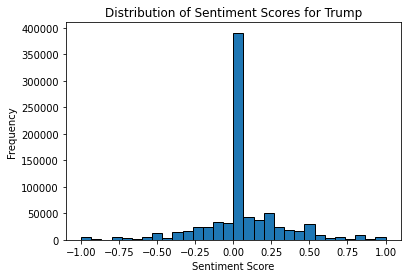

In [46]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

### Biden Data

In [47]:
df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'].value_counts()

 0.000000    192974
 0.500000     11775
 0.800000      7973
 0.250000      6450
 0.300000      6058
              ...  
-0.205455         1
 0.278889         1
 0.078750         1
 0.083168         1
-0.012240         1
Name: sentiment, Length: 9386, dtype: int64

In [48]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] < 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
17,"""The only people stupid enough to believe #Joe...",tweet,NaN,Biden,-0.175,negative
39,The evil has been vanquished. #JoeBiden #JOEBI...,tweet,2009-07-11 02:11:26,Biden,-1.000,negative
74,Trumps just making baseless claims and it’s sa...,tweet,2020-10-30 01:10:30,Biden,-0.500,negative
79,#joebiden has plans for a path forward to the ...,tweet,concerned global citizen,Biden,-0.125,negative
96,oh shit i just realized i must tell my crush t...,tweet,"""Donna",Biden,-0.200,negative


In [49]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] == 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,0.0,neutral
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,NaN,Biden,0.0,neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,0.0,neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,0.0,neutral
6,#biden #potus #PresidentElectJoe #PresidentEle...,tweet,NaN,Biden,0.0,neutral


In [50]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] > 0)].head(5)

,comment_body,source,user_location,candidatepoll,sentiment,sentiment_category
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,NaN,Biden,0.33,positive
5,Joe Biden is the best thing that happened in 2...,tweet,NaN,Biden,1.00,positive
7,This will really sting the orange toady. World...,tweet,135.0,Biden,0.20,positive
10,"""I hope the first thing @BarackObama said to @...",tweet,"preppy-goth-hippie.""",Biden,0.25,positive
11,"""happy with the triumph of JOE BIDEN",tweet,"3016159752 Y 3145304871""",Biden,0.80,positive


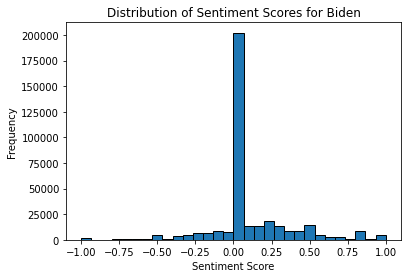

In [51]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Data Source Proportions with Clean Data

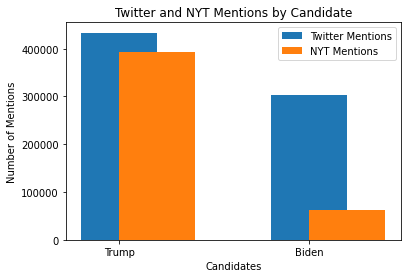

In [54]:
candidate = ['Trump','Biden']
twitter_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[0], 
             df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[0]]
nyt_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[1], 
         df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

# Additional Feature Engineering

## Create Outcome Variable

In [52]:
df_combined['SentimentOutcome'] = df_combined['candidatepoll']+"_"+df_combined['sentiment_category']

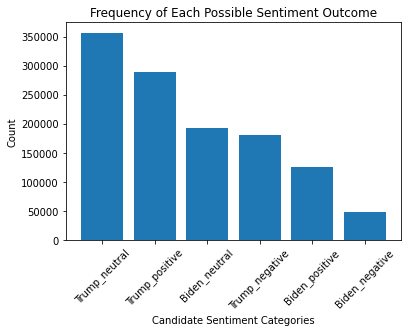

In [53]:
category_counts = df_combined['SentimentOutcome'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Candidate Sentiment Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.ylabel('Count')
plt.title('Frequency of Each Possible Sentiment Outcome')
plt.show()

## Smallest category is Biden_negative. Check number. When using train/test/split with 90/5/5 ratio, we will have to balance categories to have 43,116 observationse each based on 90% of the smallest category.

In [55]:
 df_combined[df_combined['candidatepoll'] == 'Biden']['SentimentOutcome'].value_counts()

Biden_neutral     192974
Biden_positive    124559
Biden_negative     47907
Name: SentimentOutcome, dtype: int64

## Location EDA

In [41]:
# creat colored maps by state based on sentiment

# Data Partition

### Assign input and outcome variables

In [56]:
X = df_combined[['comment_body']]  # Add state ID back in later 'state_id'
y = df_combined['SentimentOutcome']

### Create a 90/5/5 data split

In [57]:
from sklearn.model_selection import train_test_split

# Split data into 90% train and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Split remaining data (90% train) into 90% train and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=1)

### Further undersample the training set so that each level of the outcome variable is equal

In [59]:
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

# Undersample the training set to balance the six categorical outcome levels
undersampler = RandomUnderSampler(sampling_strategy='all', random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.9 MB/s eta 0:00:00:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Verify split datasets size

In [69]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230340 entries, 129005 to 377157
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_body  230340 non-null  object
dtypes: object(1)
memory usage: 3.5+ MB


In [61]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119113 entries, 853897 to 606574
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_body  119113 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [62]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119113 entries, 269675 to 443854
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_body  119113 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [70]:
X_train_resampled.shape, X_test.shape, X_val.shape

((230340, 1), (119113, 1), (119113, 1))

In [71]:
X_train_resampled.head()

,comment_body
129005,'#SNL' host #DaveChappelle urges #Biden voters...
227771,America will be in far worse shape by January ...
65243,@oliverdarcy @BretBaier You're out of your min...
252276,The VP was running behind schedule so his Secr...
31151,"""@ScorpioOfficial @EVerastegui @Scaramucci @Jo..."


## Verify balance of training set

In [68]:
y_train_resampled.value_counts()

Trump_neutral     38390
Biden_negative    38390
Biden_neutral     38390
Biden_positive    38390
Trump_negative    38390
Trump_positive    38390
Name: SentimentOutcome, dtype: int64

# Text Entry Preprocessing and Data Transformation Pipeline

In [81]:
#!pip install gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import re

# Define a function to clean text data
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces while preserving at least one space between words
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Treat hashtags and mentions as additional words
    text = re.sub(r'([#@])', r' \1 ', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    return text

# Define custom transformer for Word2Vec embeddings
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_count=1, workers=4):
        self.word2vec_model = Word2Vec(window=window, min_count=min_count, workers=workers)
    
    def fit(self, X, y=None):
        # Preprocess text data and train Word2Vec model
        X_clean = [clean_text(text) for text in X]
        X_word_lists = [text.split() for text in X_clean]
        self.word2vec_model.build_vocab(X_word_lists)
        self.word2vec_model.train(X_word_lists, total_examples=len(X_word_lists), epochs=10)
        return self
    
    def transform(self, X):
    # Clean the text data
        X_clean = [clean_text(text) for text in X]
    
    # Split text into word lists
        X_word_lists = [text.split() for text in X_clean]

    # Initialize a list to store word embeddings
        embeddings = []

    # Iterate over each word list
        for word_list in X_word_lists:
        # Initialize a list to store word embeddings for this word list
            word_embeddings = []
        # Iterate over each word in the word list
            for word in word_list:
            # Check if the word exists in the Word2Vec model's vocabulary
                if word in self.word2vec_model.wv:
                # Retrieve the word embedding and append it to the list
                    word_embeddings.append(self.word2vec_model.wv[word])
                else:
                # If the word doesn't exist in the vocabulary, append zeros
                    word_embeddings.append([0] * self.word2vec_model.vector_size)
        # Append the word embeddings for this word list to the embeddings list
            embeddings.append(word_embeddings)
    
        return embeddings
    
    
# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('word2vec', Word2VecTransformer())
])

In [ ]:
# Clean the text data
X_train_resampled['comment_clean'] = X_train_resampled['comment_body'].apply(clean_text)
X_test['comment_clean'] = X_test['comment_body'].apply(clean_text)
X_val['comment_clean'] = X_val['comment_body'].apply(clean_text)

In [ ]:
# Fit and transform on the training set
X_train_transformed = preprocessing_pipeline.fit_transform(X_train_resampled['comment_clean'])

# Transform the test and validation sets
X_test_transformed = preprocessing_pipeline.transform(X_test['comment_clean'])
X_val_transformed = preprocessing_pipeline.transform(X_val['comment_clean'])

In [ ]:
X_train_transformed.head()

In [ ]:
X_test_transformed.head()

In [ ]:
X_val_transformed.head()

## Prepare Dataset for Bias Analysis

In [ ]:
#import boto3
#import sagemaker
#import pandas as pd

#sess = sagemaker.Session()
#bucket = sess.default_bucket()
#role = sagemaker.get_execution_role()
#region = boto3.Session().region_name
#account_id = boto3.client("sts").get_caller_identity().get("Account")

#sm = boto3.Session().client(service_name="sagemaker", region_name=region)

#from pyathena import connect

#s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
#database_name = "dbpoliticpulsecomment"
#conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

#from textblob import TextBlob

#def analyze_tweet_sentiment(tweet_text):
    #analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    #return analysis.sentiment.polarity


# **********************DELETE PORTION ON THE TOP WHEN IT'S FINAL*************************



In [ ]:
#table_comment = "comment"

#statement = """SELECT comment_body, source, candidatepoll FROM {}.{}
#WHERE candidatepoll is not Null
    #""".format(
    #database_name, table_comment
#)
#df_combined = pd.read_sql(statement, conn)
#df_combined = df_combined.drop_duplicates()
#df_combined.info()

In [ ]:
# Run sentiment analysis textblob for all candidate
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_comment with a column 'text' containing tweet text
    #df_comment_all = df_combined[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_comment_all['sentiment_score'] = df_combined['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_combined['sentiment'] = df_comment_all['sentiment_score']


# Location Data: Top 5 States

In [ ]:
# Read csv US City from S3 ---> PLANNING TO MOVE IT IN .py AND USE PREPROCESSING JOB FROM SAGEMAKER
#git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
#df_city = pd.read_csv(git_city_loc)

#df_combined['user_location'].head(5)

In [ ]:
# PREFER TO RUN IT IN .py with SageMaker processing job
# TRY IT WITH 100 RECORD ONLY


# Create master location table
#master_location = df_city
#df_combined = df_combined.head(100)

# Function to map city and state name to state ID
#def map_state_id(city):
#    for index, loc in master_location.iterrows():
#        if city.lower() == loc['city'].lower() or city.lower() == loc['state_name'].lower():
#            return loc['state_id']
#    return None

# Apply mapping function to user location table
#df_combined['State ID'] = df_combined['user_location'].apply(map_state_id)

# Display the user location table with State ID column added


# Store Data For Modeling in Bucket

In [ ]:
#import boto3

# Specify the S3 bucket name
#bucket_name = '508group'  

# Specify the file name in S3
#file_name = 'df_combined.csv'

# Write DataFrame to a CSV file
#df_combined.to_csv(file_name, index=False)

# Create an S3 client
#s3 = boto3.client('s3')

# Upload CSV file to S3
#with open(file_name, "rb") as f:
    #s3.upload_fileobj(f, bucket_name, file_name)

#print(f"DataFrame saved as {file_name} in S3 bucket: {bucket_name}")

# Import Data for Modeling

In [ ]:
# Specify the S3 bucket name
bucket_name = '508group'  

# Specify the file name in S3
file_name = 'df_combined.csv'

# Create an S3 client
s3 = boto3.client('s3')

# Generate the URL for the file in S3
file_url = f's3://{bucket_name}/{file_name}'

# Read the CSV file directly into a DataFrame
df_combined = pd.read_csv(file_url)

# Text Preprocessing with DistilBERT and Train/Test/Split

In [ ]:
#!pip install transformers
import transformers
import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
REVIEW_BODY_COLUMN = "comment_body"

# Update IDs to start from 1
from collections import defaultdict
 
REVIEW_ID_COLUMN = "review_id"

LABEL_COLUMN = "SentimentOutcome"
LABEL_VALUES = ['Bidennegative', 'Bidenneutral', 'Bidenpositive', 'Trumpnegative', 'Trumpneutral', 'Trumppositive']


In [ ]:
#!pygmentize preprocess-scikit-text-to-bert-feature-store.py

In [ ]:
import time
from smexperiments.experiment import Experiment

timestamp = int(time.time())

experiment = Experiment.create(
    experiment_name="PoliticPulse-BERT-Experiment-{}".format(timestamp),
    description="Politic Pulse BERT Experiment",
    sagemaker_boto_client=sm,
)

experiment_name = experiment.experiment_name
print("Experiment name: {}".format(experiment_name))

In [ ]:
from smexperiments.trial import Trial

trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=experiment_name, sagemaker_boto_client=sm
)

trial_name = trial.trial_name
print("Trial name: {}".format(trial_name))

In [ ]:
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "prepare",
}

In [ ]:
print(experiment_name)
%store experiment_name

In [ ]:
print(trial_name)
%store trial_name

In [ ]:
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [ ]:
feature_store_offline_prefix = "reviews-feature-store-" + str(timestamp)

print(feature_store_offline_prefix)

In [ ]:
feature_group_name = "reviews-feature-group-" + str(timestamp)

print(feature_group_name)

In [ ]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions = [
    FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="review_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
    #    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING)
]

In [ ]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sess)

print(feature_group)

In [ ]:
processing_instance_type = "ml.c5.xlarge"
processing_instance_count = 2
train_split_percentage = 0.90
validation_split_percentage = 0.05
test_split_percentage = 0.05
balance_dataset = True
max_seq_length = 64

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

# Need to find preprocess file and update to our destination location

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

processor.run(
    code="preprocess-scikit-text-to-bert-feature-store.py",
    inputs=[
        ProcessingInput(
            input_name="raw-input-data",
            source=all_data_s3_uri,
            destination="/opt/ml/processing/input/data/",
            s3_data_distribution_type="ShardedByS3Key",
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="bert-train", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/train"
        ),
        ProcessingOutput(
            output_name="bert-validation",
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/validation",
        ),
        ProcessingOutput(
            output_name="bert-test", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/test"
        ),
    ],
    arguments=[
        "--train-split-percentage",
        str(train_split_percentage),
        "--validation-split-percentage",
        str(validation_split_percentage),
        "--test-split-percentage",
        str(test_split_percentage),
        "--max-seq-length",
        str(max_seq_length),
        "--balance-dataset",
        str(balance_dataset),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix),
        "--feature-group-name",
        str(feature_group_name),
    ],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)

# Tranformation Pipeline

In [ ]:
cats_list = ['user_location', 'source']

# Create a categorical processing pipeline that uses one-hot encoding, dropping binary columns.
cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='if_binary'))])

# Combine pipeline steps
all_pipe = make_pipeline(ColumnTransformer([('cat', cat_pipe, cats_list)],
                                          verbose_feature_names_out=False))
# Verify steps
all_pipe.named_steps

# Combine Transformed Features with BERT Transformed Text Data

# Make New Folders with Clean Datasets

In [ ]:
#Create folder
#!mkdir -p ./data-clarify/

In [ ]:
# chatgpt
# list folder
#import os

# Get the current working directory
#current_directory = "/home/sagemaker-user/ADS508_GroupProject"
#spec_dir = "/home/sagemaker-user/ADS508_GroupProject/data-clarify"

# List the contents of the directory
#for item in os.listdir(spec_dir):
    #full_path = os.path.join(spec_dir, item)
    #if os.path.isdir(full_path):
        #print(f"Directory: {item}")
    #else:
        #print(f"File: {item}")

In [ ]:
# All Data
#path = "./data-clarify/tweet_nyt_combined.csv"
#df_combined.to_csv(path, index=False, header=True)

In [ ]:
# Balance the Dataset by candidate and Sentiment score
#import matplotlib.pyplot as plt
#import seaborn as sns

#df_grouped_by = df_combined.groupby(["candidatepoll", "sentiment_category"])[["candidatepoll", "sentiment_category"]]
#df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
#df_balanced.shape

#sns.countplot(data=df_balanced, x="sentiment_category", hue="candidatepoll")

In [ ]:
#path_balance = "./data-clarify/combine_balance.csv"
#df_balanced.to_csv(path_balance, index=False, header=True)

#path_jsonlines = "./data-clarify/combine_balance.jsonl"
#df_balanced.to_json(path_or_buf=path_jsonlines, orient="records", lines=True)

### Upload Combined and Balance Data to S3

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

In [ ]:
!aws s3 ls $bias_data_s3_uri

In [ ]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_s3_uri

In [ ]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

## Run Data Bias Analysis

In [ ]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

In [ ]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

### Calculate Bias Metrics for Balanced Data

In [ ]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [ ]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [ ]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



In [ ]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


#### Download report

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

In [ ]:
_testing